#### DeepLDA: ADP

#### tutorial: https://mlcolvar.readthedocs.io/en/latest/notebooks/tutorials/intro_1_training.html
#### example notebook: https://mlcolvar.readthedocs.io/en/latest/notebooks/examples/ex_DeepLDA.html


In [80]:
#required packages

#!pip install mlcolvar 
#!conda install jupyter

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

import os
import numpy as np
import scipy 
import matplotlib.pyplot as plt
import pandas as pd
import itertools
#import progressbar

import pandas as pd
import math

#from google.colab import files

print("Using Pytorch",torch.__version__)

Using Pytorch 2.0.1+cu117


In [81]:
## NOTE: download unbiased data

#!wget https://raw.githubusercontent.com/luigibonati/masterclass-plumed/main/1_DeepLDA/0_unbiased-sA/COLVAR
#!wget https://raw.githubusercontent.com/luigibonati/masterclass-plumed/main/1_DeepLDA/0_unbiased-sB/COLVAR

#### Read and analyze unbiased dataset

In [4]:
# read data

input_A = pd.read_csv('./unbiased_data/COLVAR_A', delim_whitespace=True)
column_names = [col for col in input_A.columns if col not in ['FIELDS', '#!']]
 
input_A = pd.read_csv('./unbiased_data/COLVAR_A', 
                      delim_whitespace=True, header=None, comment="#", skiprows=1, names=column_names)

input_B = pd.read_csv('./unbiased_data/COLVAR_B', delim_whitespace=True)
column_names = [col for col in input_B.columns if col not in ['FIELDS', '#!']]
 
input_B = pd.read_csv('./unbiased_data/COLVAR_B', 
                      delim_whitespace=True, header=None, comment="#", skiprows=1, names=column_names)

print("[Imported data]")
print("INPUTS.A.shape:", input_A.shape)
print("INPUTS.B.shape:", input_B.shape)



[Imported data]
INPUTS.A.shape: (5001, 51)
INPUTS.B.shape: (5001, 51)


#### check A and B samples

Text(0, 0.5, '$\\psi$')

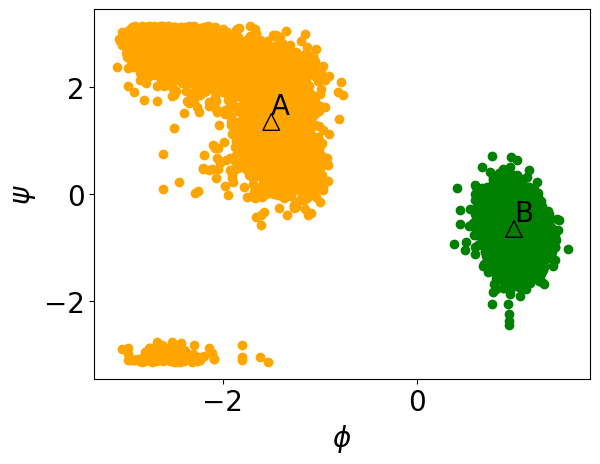

In [5]:
#### assume sin1,cos1 is phi and sin2,cos2 is psi

font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 20}

plt.rc('font', **font)

#plt.scatter(np.arctan2(input_A['sin1'], input_A['cos1']), np.arctan2(input_A['sin2'], input_A['cos2']), color='orange')
#plt.scatter(np.arctan2(input_B['sin1'], input_B['cos1']), np.arctan2(input_B['sin2'], input_B['cos2']), color='green')


plt.scatter(input_A['phi'], input_A['psi'], color='orange')
plt.scatter(input_B['phi'], input_B['psi'], color='green')


plt.annotate('A', xy =(-1.5, 1.5), xytext =(-1.5, 1.5), arrowprops = dict(facecolor ='orange'), size=20)
plt.annotate('B', xy =(1, -0.5), xytext =(1, -0.5), arrowprops = dict(facecolor ='green'), size=20)

plt.xlabel(r'$\phi$')
plt.ylabel(r'$\psi$')




###### label input features  and visualize the features

input_A_features.shape: (5001, 52)
input_B_features.shape: (5001, 52)
input_features.shape: (10002, 52)


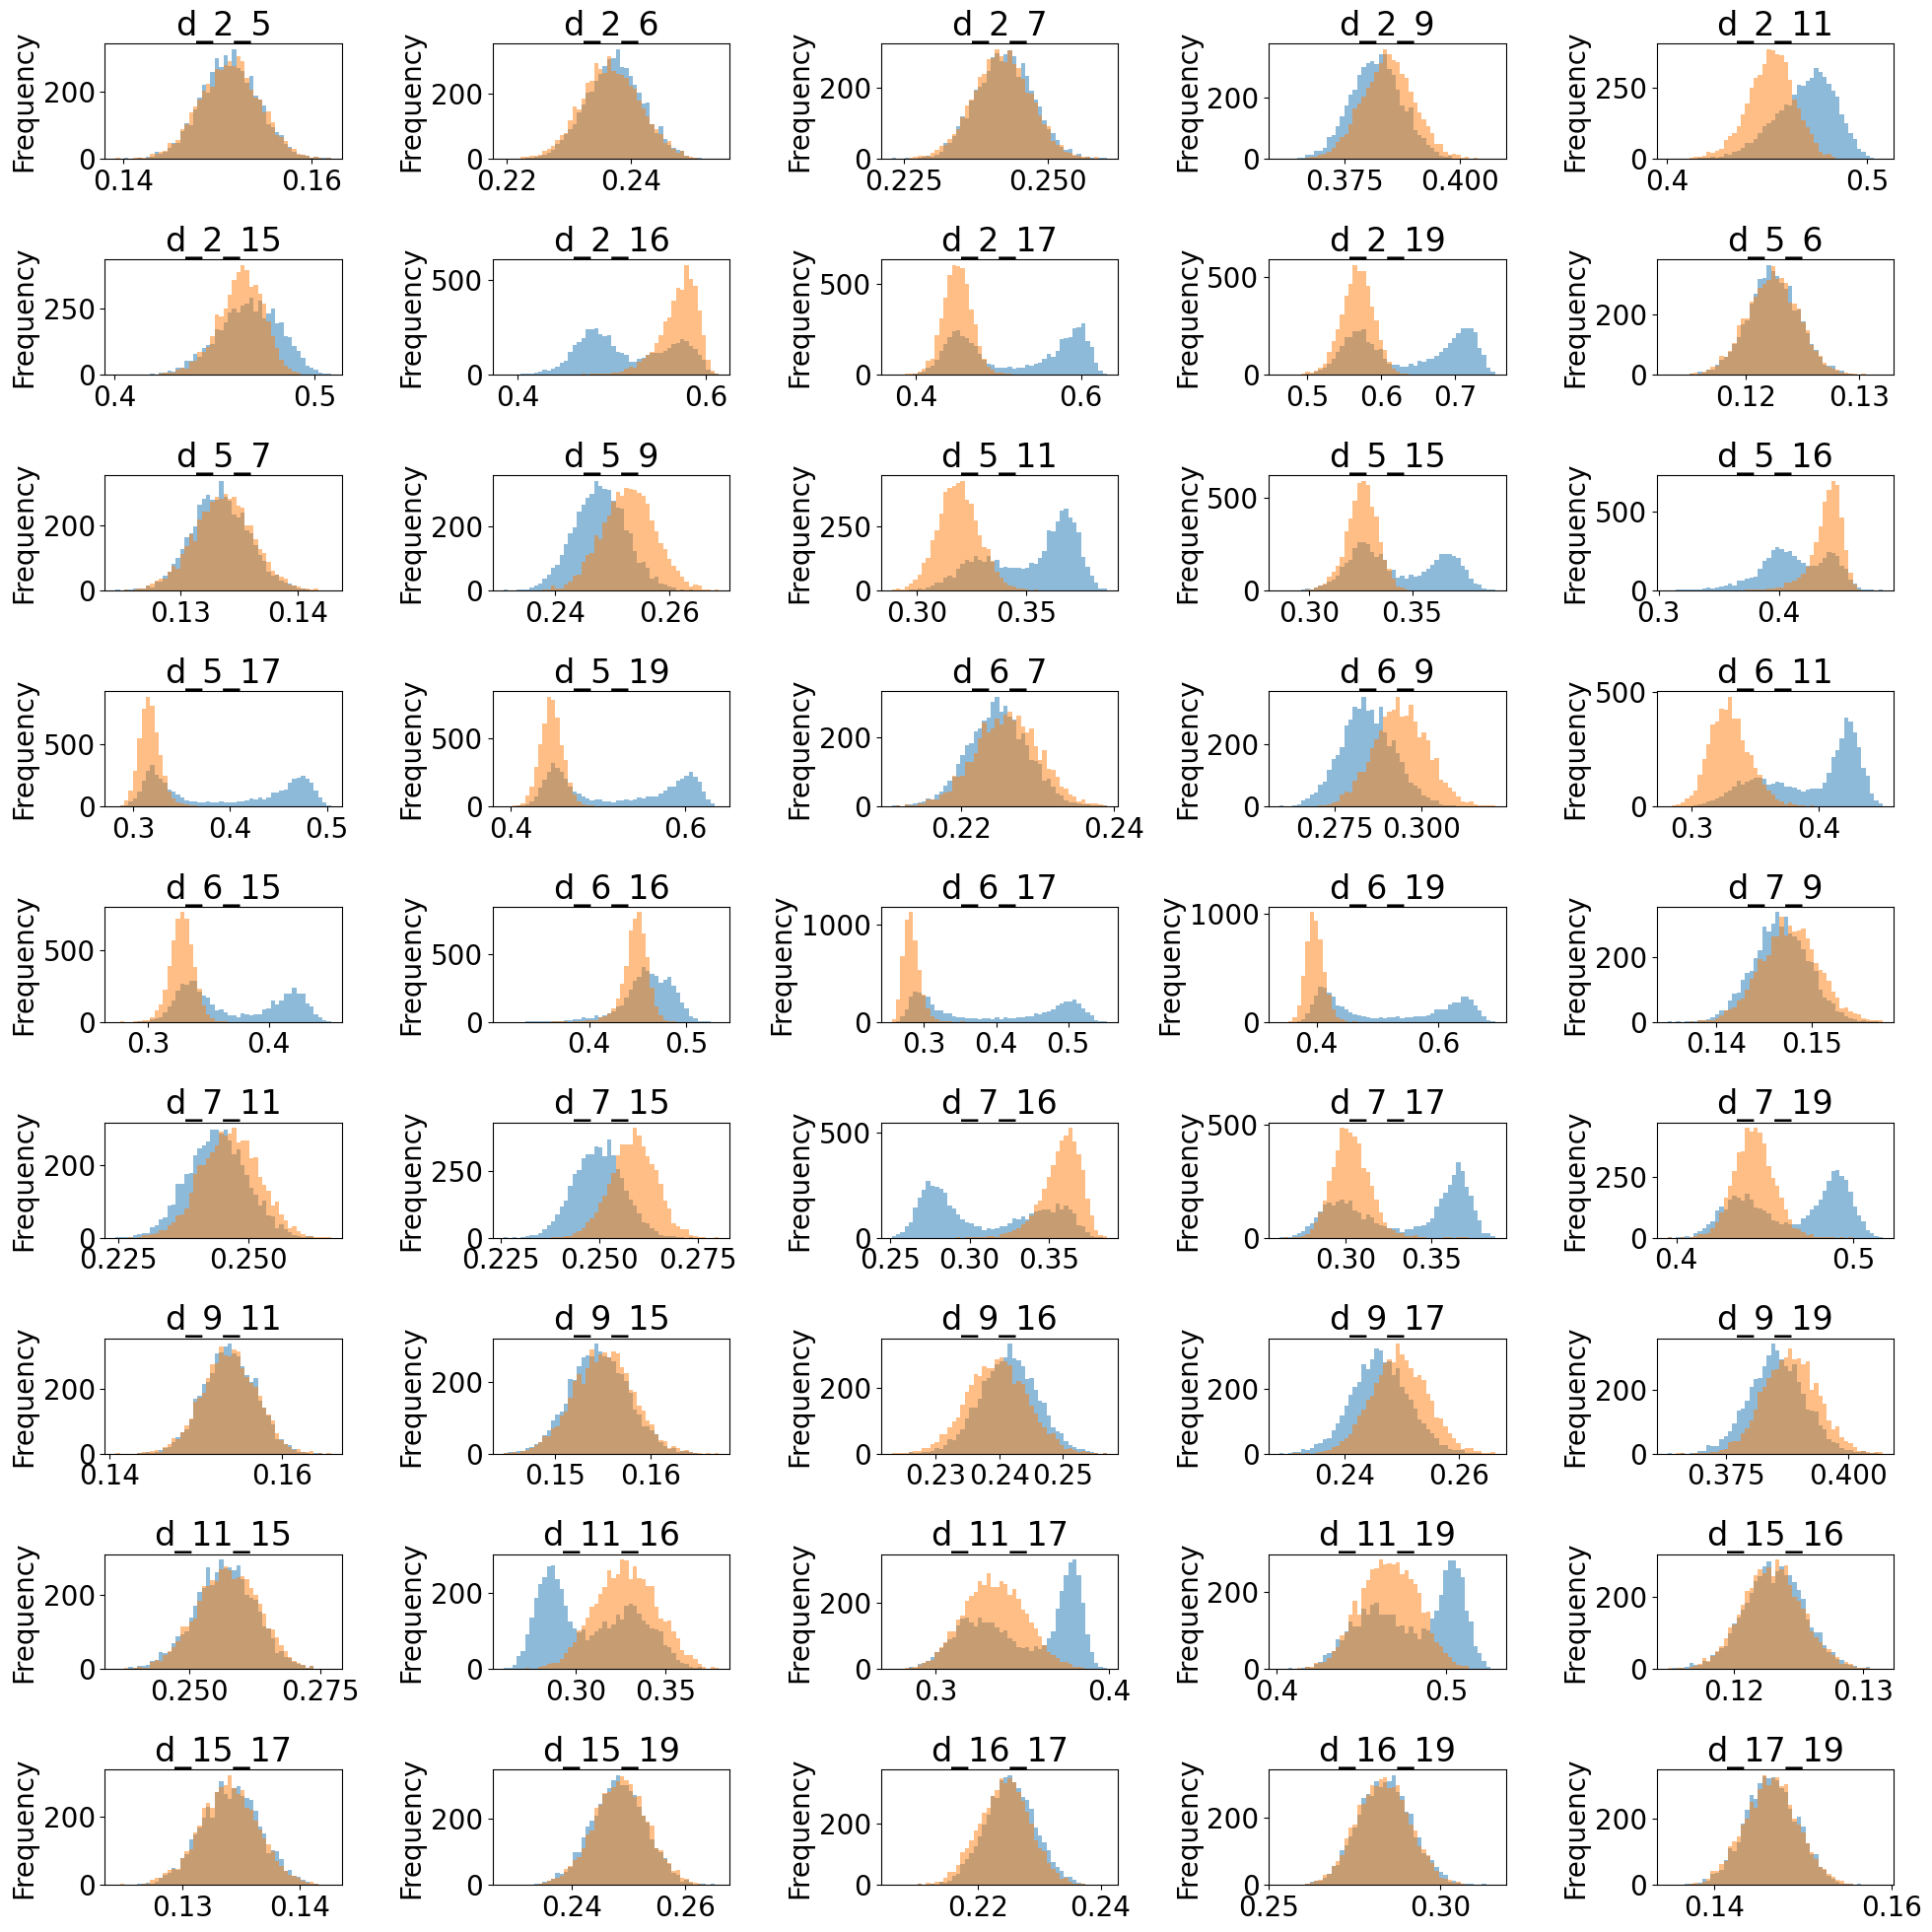

In [6]:
input_A_features = input_A.copy()
input_A_features.loc[:, 'label'] = np.zeros(input_A_features.shape[0])
input_B_features = input_B.copy()
input_B_features.loc[:, 'label'] = np.ones(input_B_features.shape[0])


print("input_A_features.shape:", input_A_features.shape)
print("input_B_features.shape:", input_B_features.shape)

#### combine both A and B

input_features = pd.concat((input_A_features, input_B_features))

print("input_features.shape:", input_features.shape)


# visualize features
fig,axs = plt.subplots(9,5,figsize=(20,20),sharey=False)

descriptors_names = input_features.filter(regex='d_').columns.values

for ax,desc in zip(axs.flatten(),descriptors_names):
    input_features.pivot(columns='label')[desc].plot.hist(bins=50,alpha=0.5,ax=ax,legend=False)
    ax.set_title(desc)

plt.tight_layout()

#### LDA, HLDA and DeepLDA

In [63]:
# Set seed for reproducibility
torch.manual_seed(42)

#### prepare dataset # only pairwise distances
X = torch.tensor(input_features[input_features.filter(regex='d_').columns.values].values, dtype=torch.float32)
labels = torch.tensor(input_features['label'].values, dtype=torch.float32)


#### LDA

In [64]:
from mlcolvar.core.stats import LDA

n_states = 2
# define LDA object
lda = LDA(in_features=X.shape[1], n_states=n_states, mode='standard')

# compute vectors that most discriminate the states
eigvals, eigvecs = lda.compute(X,labels)

#eigvals, eigvecs
eigvals.shape, eigvecs.shape


(torch.Size([1]), torch.Size([45, 1]))

In [65]:
# evaluate cv on training set and append to dataframe
s = lda.forward(torch.Tensor(X)).numpy()

n_components = n_states-1

for i in range(n_components):
    input_features[f'CV{i}'] = s[:,i]

In [66]:
#input_features

#### visualize LDA along phi and psi

Text(0, 0.5, '$\\psi$')

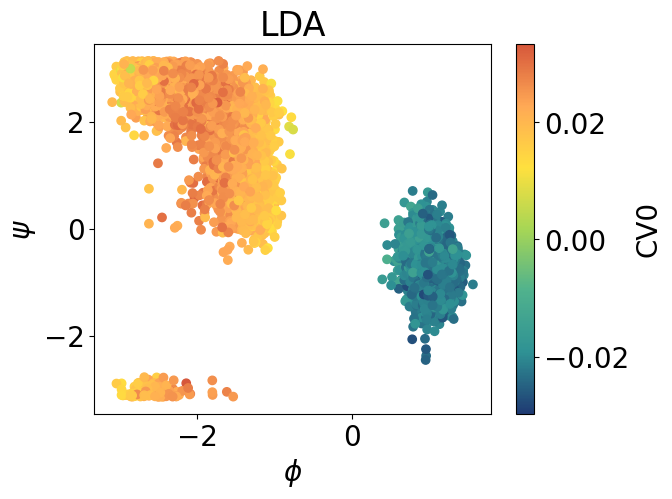

In [67]:
#### assume sin1,cos1 is phi and sin2,cos2 is psi

font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 20}

plt.rc('font', **font)

#plt.scatter(np.arctan2(input_features['sin1'], input_features['cos1']), 
#            np.arctan2(input_features['sin2'], input_features['cos2']), 
#            c=all_input_features['label'])

sc = plt.scatter(input_features['phi'], input_features['psi'], 
                c=input_features[f'CV{0}'], cmap='fessa')

plt.title('LDA')


cb = plt.colorbar(sc)
cb.set_label(f'CV{0}')

plt.xlabel(r'$\phi$')
plt.ylabel(r'$\psi$')




#### HLDA --- has some errors

In [68]:
from mlcolvar.core.stats import LDA

n_states = 2

hlda = LDA(in_features=X.shape[1], n_states=n_states, mode='harmonic')

# compute vectors that most discriminate the states
eigvals, eigvecs = hlda.compute(X,labels)
eigvals.shape, eigvecs.shape

# evaluate cv on training set and append to dataframe
s = lda.forward(torch.Tensor(X)).numpy()

n_components = n_states-1

for i in range(n_components):
    input_features[f'CV{i}'] = s[:,i]

ValueError: ('The matrices need to be symmetric to solve the generalized eigenvalue problem via cholesky decomposition. A >> ', tensor([[ 7.3791e-06,  6.4643e-06,  5.7910e-06,  ..., -6.8389e-08,
         -2.7481e-07, -2.0223e-07],
        [ 6.4642e-06,  1.7281e-05, -6.8185e-08,  ..., -7.9619e-08,
         -5.6872e-07, -1.0149e-07],
        [ 5.7914e-06, -6.7815e-08,  1.9532e-05,  ...,  7.0337e-08,
          4.4725e-07, -1.3016e-07],
        ...,
        [-6.8184e-08, -7.9406e-08,  7.0540e-08,  ...,  1.3144e-05,
          1.3544e-05, -4.0734e-07],
        [-2.7444e-07, -5.6838e-07,  4.4699e-07,  ...,  1.3543e-05,
          4.8577e-05,  2.8190e-06],
        [-2.0222e-07, -1.0139e-07, -1.3009e-07,  ..., -4.0731e-07,
          2.8190e-06,  6.7723e-06]]))

In [13]:
X.shape, labels.shape

(torch.Size([10002, 45]), torch.Size([10002]))

#### Deep LDA

In [82]:
from mlcolvar.cvs import DeepLDA

#### prepare dataset
from mlcolvar.data import DictModule,DictDataset
# create datamodule for trainer

dataset = DictDataset({'data': X, 'labels': labels})
datamodule = DictModule(dataset,lengths=[0.8,0.2]) #lengths=[0.8,0.2] -- this is training and validation split
datamodule


n_states = 2
n_components = n_states-1
n_input = dataset['data'].shape[-1]
nodes = [n_input,30,30,2]
# MODEL
model = DeepLDA(nodes, n_states=n_states)

In [84]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from mlcolvar.utils.trainer import MetricsCallback
from lightning import Trainer

# define callbacks
metrics = MetricsCallback()
early_stopping = EarlyStopping(monitor="valid_loss", min_delta=0.1, patience=50)


#device_id = 0  # Integer representation of the device ID
#device = torch.device(f"cuda:{device_id}" if torch.cuda.is_available() else "cpu")

from lightning.pytorch.loggers import CSVLogger

logger = CSVLogger(save_dir="experiments",   # directory where to save file
                    name='myCV',             # name of experiment
                    version=None             # version number (if None it will be automatically assigned)
                    )

# define trainer
trainer = Trainer(callbacks=[metrics, early_stopping],
                  max_epochs=1000, logger=logger, enable_checkpointing=False, devices=[2])

# fit
trainer.fit(model, datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name    | Type                  | Params | In sizes | Out sizes
-------------------------------------------------------------------------
0 | loss_fn | ReduceEigenvaluesLoss | 0      | ?        | ?        
1 | norm_in | Normalization         | 0      | [45]     | [45]     
2 | nn      | FeedForward           | 2.4 K  | [45]     | [2]      
3 | lda     | LDA                   | 0      | [2]      | [1]      
-------------------------------------------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.009     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

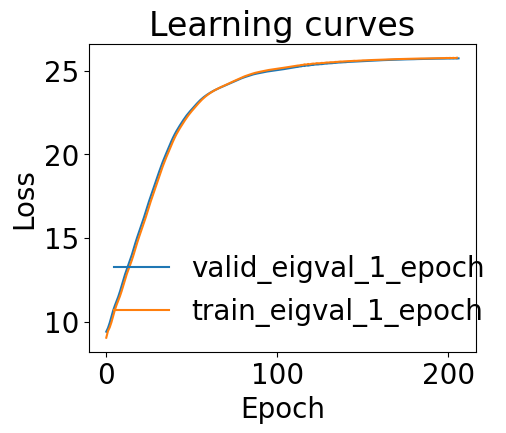

In [54]:
from mlcolvar.utils.plot import plot_metrics

ax = plot_metrics(metrics.metrics,
                  keys=[x for x in  metrics.metrics.keys() if 'eigval' in x and 'epoch' in x],#['train_loss_epoch','valid_loss'],
                  yscale='linear')



#### Analysis of CV

In [56]:
# evaluate cv on training set and append to dataframe
X = dataset[:]['data']
model.eval()
with torch.no_grad():
    s = model(torch.Tensor(X)).numpy()

n_components = n_states-1

for i in range(n_components):
    input_features[f'CV{i}'] = s[:,i]


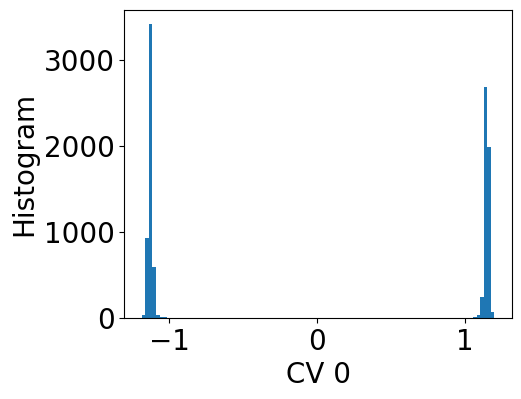

In [58]:
fig,axs = plt.subplots(1,n_components,figsize=(5*n_components,4))
if n_components == 1:
    axs = [axs]

for i,ax in enumerate(axs):
    ax.hist(s[:,i],bins=100)
    ax.set_xlabel(f'CV {i}')
    ax.set_ylabel('Histogram')

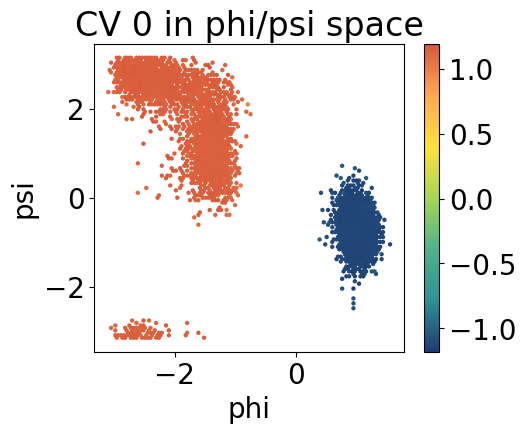

In [60]:
n_components = n_states-1

fig,axs = plt.subplots(1,n_components,figsize=(5*n_components,4))
if n_components == 1:
    axs = [axs]

for i,ax in enumerate(axs):
    input_features.plot.hexbin('phi','psi',C=f'CV{i}',cmap='fessa',ax=ax)
    ax.set_title(f'CV {i} in phi/psi space')

In [73]:
#### save model

model.to_torchscript('model.ptc',method="trace")

DeepLDA(
  original_name=DeepLDA
  (loss_fn): ReduceEigenvaluesLoss(original_name=ReduceEigenvaluesLoss)
  (norm_in): Normalization(original_name=Normalization)
  (nn): FeedForward(
    original_name=FeedForward
    (nn): Sequential(
      original_name=Sequential
      (0): Linear(original_name=Linear)
      (1): ReLU(original_name=ReLU)
      (2): Linear(original_name=Linear)
      (3): ReLU(original_name=ReLU)
      (4): Linear(original_name=Linear)
    )
  )
  (lda): LDA(original_name=LDA)
)

#### Prepare PLUMED file for enhanced sampling

In [79]:
# get vectors for computing angles

plumedFile=open('plumed_deeplda.dat','w')

        
#### feature calculations
plumedFile.write('\n')

plumedFile.write('#Define features\n')
atoms_list = [5,7,9,15,17] #NOTE: REPLACE with list of atoms in distance pairs used for training the model
count_pair=0
for atom_i in range(len(atoms_list)):
    for atom_j in range(len(atoms_list)):
        
        if atom_i < atom_j:
        
            plumedFile.write('d'+str(count_pair)+':  DISTANCE ATOMS=' + str(atoms_list[atom_i]) + ',' + str(atoms_list[atom_j]) )
                             
            plumedFile.write('\n')
            
            count_pair+=1
            
plumedFile.write('\n')
plumedFile.write('\n')

plumedFile.write('#LOAD PYTORCH MODEL\n')
plumedFile.write('deep: PYTORCH_MODEL FILE=model.ptc ARG=')
count_pair=0
for atom_i in range(len(atoms_list)):
    for atom_j in range(len(atoms_list)):
        
        if atom_i < atom_j:
            plumedFile.write('d'+str(count_pair)+',')
            
            count_pair+=1

plumedFile.write('\n')
plumedFile.write('\n')


plumedFile.write('#DEFINE METAD CALCULATION\n')
plumedFile.write('METAD ...\n')
plumedFile.write('LABEL=metad\n')
plumedFile.write('ARG=deep.node-0\n')
plumedFile.write('PACE=500\n')
plumedFile.write('SIGMA=0.025\n')
plumedFile.write('BIASFACTOR=10\n')
plumedFile.write('TEMP=300.0\n')
plumedFile.write('GRID_MIN=-2\n')
plumedFile.write('GRID_MAX=2\n')
plumedFile.write('GRID_BIN=750\n')
plumedFile.write('CALC_RCT\n')
plumedFile.write('... METAD\n\n')

plumedFile.write('#MONITOR DIHEDRAL ANGLES\n')
plumedFile.write('phi: TORSION ATOMS=5,7,9,15\n')
plumedFile.write('psi: TORSION ATOMS=7,9,15,17\n\n')

#PRINT
plumedFile.write('PRINT STRIDE=500 ARG=deep.node-0,phi,psi,opes FILE=COLVAR')


plumedFile.write('\n')

plumedFile.close()


